读取一个 $400 \times 500$的图片

RuntimeError: module compiled against API version 0xc but this version of numpy is 0xb

RuntimeError: module compiled against API version 0xc but this version of numpy is 0xb

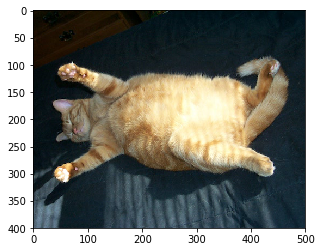

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from mxnet import image

img = image.imdecode(open('../img/cat1.jpg', 'rb').read())
plt.imshow(img.asnumpy())

In [2]:
from mxnet import nd
import sys
sys.path.append('..')
import utils

def apply(img, aug, n=3):
    # 转成float，一是因为aug需要float类型数据来方便做变化。
    #二是这里会有一次copy操作，因为有些aug直接通过改写输入
    #(而不是新建输出)获取新能的提升
    X = [aug(img.astype('float32')) for _ in range(n*n)]
    # 有些aug不保证输入是合法值，所以做一次clip
    # 显示浮点图片时imshow要求输入在[0,1]之间
    Y = nd.stack(*X).clip(0, 255)/255
    utils.show_images(Y, n, n, figsize=(8, 8))

#### 变形

水平方向翻转图片是最早也是使用最广泛的一种增广

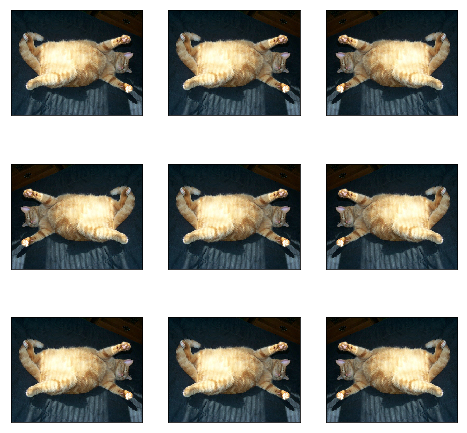

In [3]:
# 以.5的概率做翻转
aug = image.HorizontalFlipAug(.5)
apply(img, aug)

样例图片里我们关心的猫在图片正中间，但一般情况下可能不是这样。前面我们提到池化层能弱化卷积层对目标位置的敏感度，但也不能完全解决这个问题。一个常用增广方法是随机的截取其中的一块。

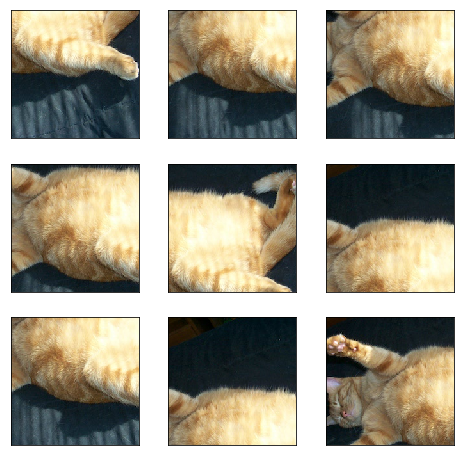

In [4]:
# 随机截取一块 200* 200的区域
aug = image.RandomCropAug([200, 200])
apply(img, aug)

随机裁剪一块随机大小的区域

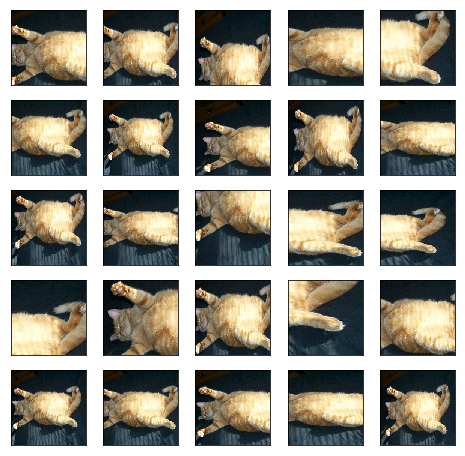

In [5]:
# 随机裁剪， 要求保留至少0.1的区域，随机长宽比在.5和2之间
# 最后将结果resize到200*200
aug = image.RandomSizedCropAug((200, 200), .1, (.5, 2))
apply(img, aug, n =5)

#### 颜色变化

形状变化外的一个另一大类是变化颜色

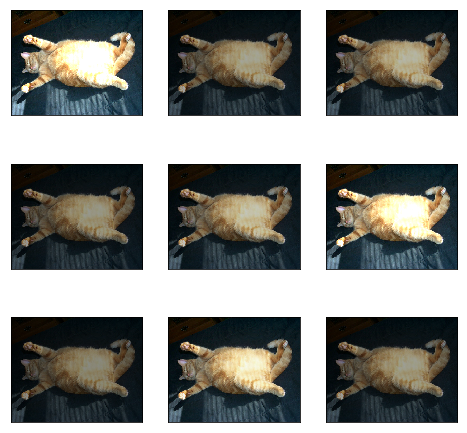

In [6]:
# 随机将亮度增加或减少在0-50%间的一个量
aug = image.BrightnessJitterAug(.5)
apply(img, aug)

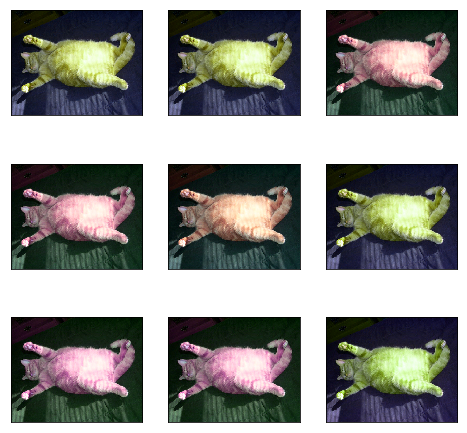

In [7]:
# 随机颜色变化
aug = image.HueJitterAug(.5)
apply(img, aug)

#### 数据读取

In [8]:
# 对图片按顺序应用数个增广
def apply_aug_list(img, augs):
    for f in augs:
        img = f(img)
    return img

对于训练图片我们随机水平翻转和剪裁。对于测试图片仅做中心裁剪。CIFAR10图片尺寸是$32 \times 32 \times 3$，我们裁剪成$28 \times 28 \times 3$

In [9]:
train_augs = [
    image.HorizontalFlipAug(.5),
    image.RandomCropAug((28, 28))
]

test_augs = [
    image.CenterCropAug((28, 28))
]

In [10]:
from mxnet import nd, gluon
import sys
sys.path.append('..')
import utils

def get_transform(augs):
    def transform(data, label):
        # data: sample * height * width * channel
        # label: sample
        data = data.astype('float32')
        if augs is not None:
            data = nd.stack(*[apply_aug_list(d, augs) for d in data])
        data = nd.transpose(data, (0, 3, 1, 2))
        return data, label.astype('float32')
    return transform

def get_data(batch_size, train_augs, test_augs=None):
    cifar10_train = gluon.data.vision.CIFAR10(train=True, transform=get_transform(train_augs))
    cifar10_test = gluon.data.vision.CIFAR10(train=False, transform=get_transform(test_augs))
    train_data = utils.DataLoader(cifar10_train, batch_size, shuffle=True)
    test_data = utils.DataLoader(cifar10_test, batch_size, shuffle=False)
    return (train_data, test_data)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

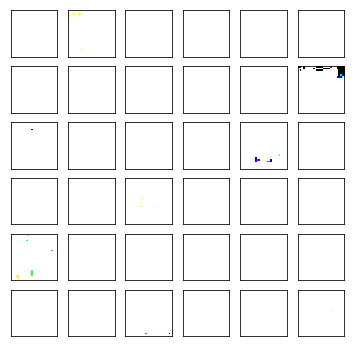

In [11]:
train_data, _ = get_data(36, train_augs)
for imgs, _ in train_data:
    break
utils.show_images(imgs.transpose((0, 2, 3, 1)), 6, 6)

In [12]:
imgs.shape

(36, 3, 28, 28)

#### 训练
使用`ResNet 18`训练。

In [13]:
from mxnet import init

def train(train_augs, test_augs, learning_rate=.1):
    batch_size = 128
    num_epochs = 10
    ctx = utils.try_all_gpus()
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    train_data, test_data = get_data(batch_size, train_augs, test_augs)
    net = utils.resnet18(10)
    net.initialize(ctx=ctx, init=init.Xavier())
    net.hybridize()
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': learning_rate})
    utils.train(train_data, test_data, net, loss, trainer, ctx, num_epochs)

使用增广

In [14]:
train(train_augs, test_augs)

Start training on  [cpu(0)]


KeyboardInterrupt: 

不使用增广

In [ ]:
train(test_augs, test_augs)